# Comparison Fibre Injection Efficiency ESO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc


## Reproduction of equation of ESPRESSO article (see: https://academic.oup.com/mnras/article/532/2/1635/7697165)

In [2]:

"""
For a given fibre diameter (Df) and shape parameter ⁠\beta,
The transmission as a function of the IQ FWHM, \theta, can be expressed as:
"""

# Gaussian profile
def T_gaussian(theta, Df):
    return 1 - np.exp(-0.5 * (np.sqrt(2 * np.log(2)) * Df / theta)**2)

# Five-thirds profile
def T_five_thirds(theta, Df):
    x = np.log(2) * (Df / theta)**(5/3)
    return gammainc(6/5, x)

# Moffat profile
def T_moffat(theta, Df, beta):
    factor = (2**(1/beta) - 1)
    return 1 - (1 + factor * (Df/theta)**2)**(1 - beta)

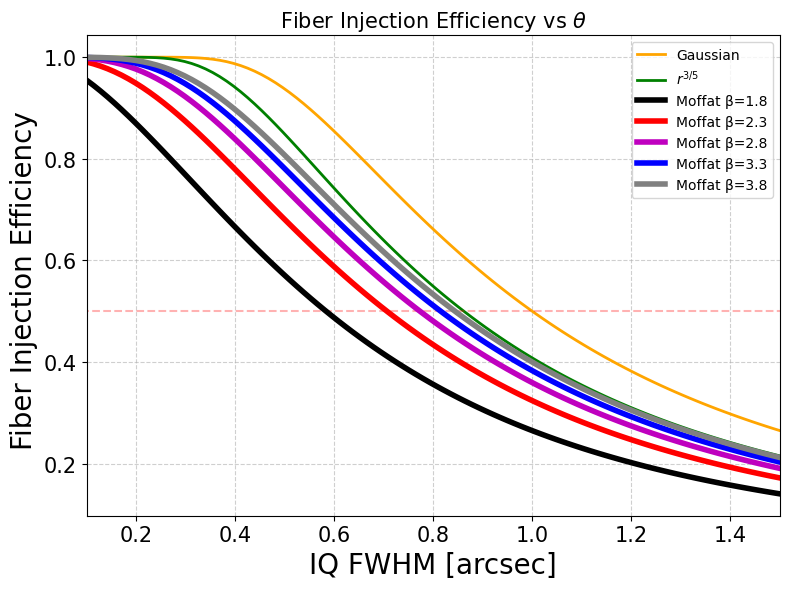

In [5]:
# Set up theta values
theta = np.linspace(0.1, 1.5, 100)  # avoid theta = 0 to prevent division by zero
Df = 1.0  # To Play! Fibre diameter in arcsec


# Plotting
plt.figure(figsize=(8, 6))

# Plot Gaussian
plt.plot(theta, T_gaussian(theta, Df),color='orange', label='Gaussian', linewidth=2)

# Plot Five-Thirds
plt.plot(theta, T_five_thirds(theta, Df), label=r'$r^{3/5}$', color='green', linewidth=2)

plt.plot([0,1.5],[0.5,0.5], '--', color='r', alpha=0.3)

# Plot Moffat for various beta
betas = [1.8, 2.3, 2.8, 3.3, 3.8] # [2.3, 2.8, 3.3, 3.8, 100]
colors = ['k', 'r','m','b','gray']
for i, beta in enumerate(betas):
    plt.plot(theta, T_moffat(theta, Df, beta), linestyle='-', label=f'Moffat β={beta:.1f}',
             linewidth=4, color=colors[i])#'darkblue')

# Customize plot
plt.xlabel(r'IQ FWHM [arcsec]', fontsize=20)
plt.ylabel(r'Fiber Injection Efficiency ', fontsize=20)
plt.title(r'Fiber Injection Efficiency vs $\theta$', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.xlim(0.1,1.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
#plt.savefig('Fiber_Injection_Efficiency_Article.pdf')
plt.show()


## Modified version of the get_seeing_fwhm function of PYETC

In [4]:
def get_seeing_fwhm(seeing, airmass, wave, diam, iq_ins):
    """ compute FWHM for the Paranal ESO ETC model

    Parameters
    ----------
    seeing : float
        seeing (arcsec) at 5000A
    airmass : float
        airmass of the observation
    wave : numpy array of float
        wavelengths in A
    diam : float
        telescope primary mirror diameter in m
    iq_ins : float of numpy array
        image quality of the telescope + instrument

    Returns
    -------
    numpy array of float
        FWHM (arcsec) as function of wavelengths

    """
    r0,l0 = 0.188,46 # for VLT (in ETC)
    r0    = 0.1*seeing**(-1)*(wave/5000)**(1.2)*airmass**(-0.6)
    Fkolb = 1/(1+300*diam/l0)-1
    iq_atm = seeing*(wave/5000)**(-1/5)*airmass**(3/5) * \
        np.sqrt(1+Fkolb*2.183*(r0/l0)**0.356)
    iq = np.sqrt(iq_atm**2 + iq_ins**2)
    return iq

In [6]:
#Test for a set of given parameters to the ETC of GIRAFFE

get_seeing_fwhm(1.0,1.5,3857,8.2,0.01)

1.2028812114029095

## Comparing with Fibre injection efficiency of GIRAFFE LR mode at 3857A, for different seeing and airmass

In [7]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.0
wave    = np.arange(3600,4100, 5)
diam    = 8.2
iq_ins  = 0.01 #0.01 for only the telescope, 0.4 if the instrument is considered

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [8]:
#ESO ETC
wv_refe  = 3857 #Central wavelenght for GIRAFFE LR mode
eff_loss = [0.159,0.314,0.516] # Values obatained from ESO ETC
fib_effi = [1-x for x in eff_loss]

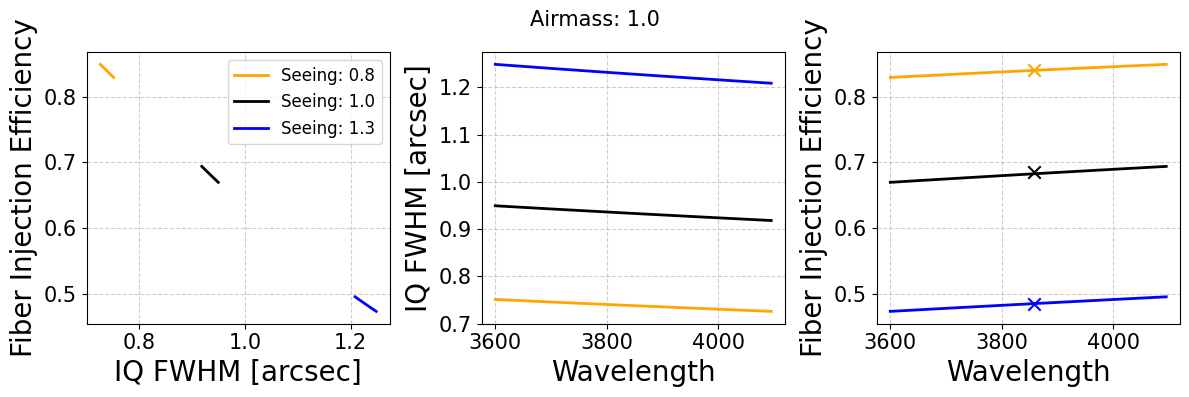

In [9]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.0', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1.pdf')
plt.show()


## Same as before, but for airmass equal to 1.5

In [11]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.5
wave    = np.arange(3600,4100, 5)
diam    = 8.2
iq_ins  = 0.01

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [12]:
#ESO ETC
wv_refe  = 3857
eff_loss = [0.329,0.499,0.670]
fib_effi = [1-x for x in eff_loss]

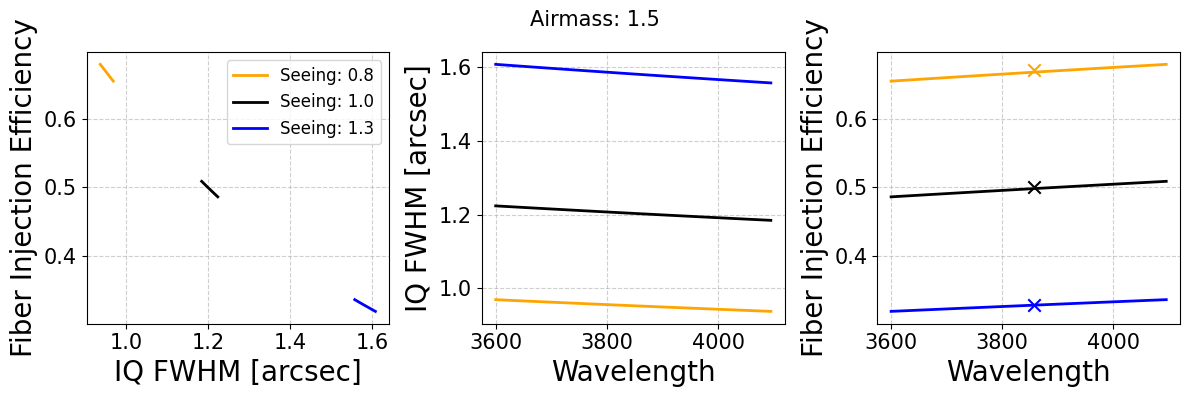

In [13]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.5', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1.5.pdf')
plt.show()

## Same as before, but for airmass equal to 2.0

In [14]:
seeing  = [0.8, 1.0, 1.3]
airmass = 2.0 
wave    = np.arange(3600,4100, 5)
diam    = 8.2
iq_ins  = 0.01

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [15]:
#ESO ETC
wv_refe  = 3857
eff_loss = [0.463,0.617,0.756]
fib_effi = [1-x for x in eff_loss]

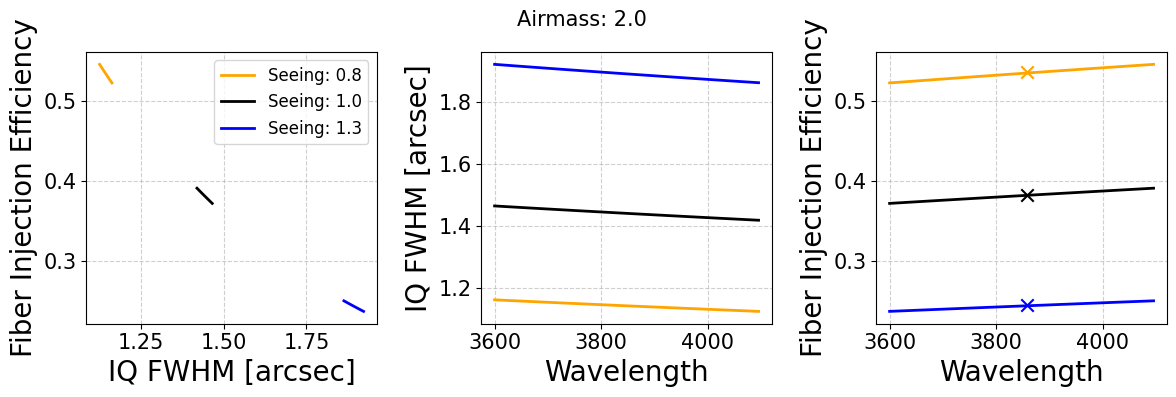

In [16]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 2.0', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass2.pdf')
plt.show()

## Let's try the same for another GIRAFFE mode (FOR LR04@543.1)

In [17]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.0 
wave    = np.arange(5000,5900, 5)
diam    = 8.2
iq_ins  = 0.014 #0.014 for only the telescope for LR04

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [18]:
#ESO ETC
wv_refe  = 5431
eff_loss = [0.106,0.249,0.450]
fib_effi = [1-x for x in eff_loss]

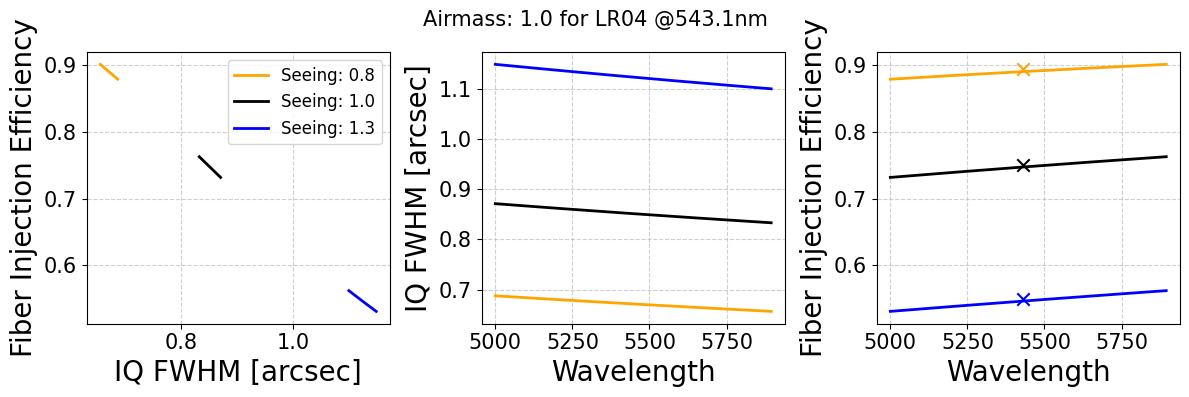

In [19]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.0 for LR04 @543.1nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1_LR04.pdf')
plt.show()


In [20]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.5
wave    = np.arange(5000,5900, 5)
diam    = 8.2
iq_ins  = 0.014 #0.014 for only the telescope for LR04

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [21]:
#ESO ETC
wv_refe  = 5431
eff_loss = [0.266,0.437,0.622]
fib_effi = [1-x for x in eff_loss]

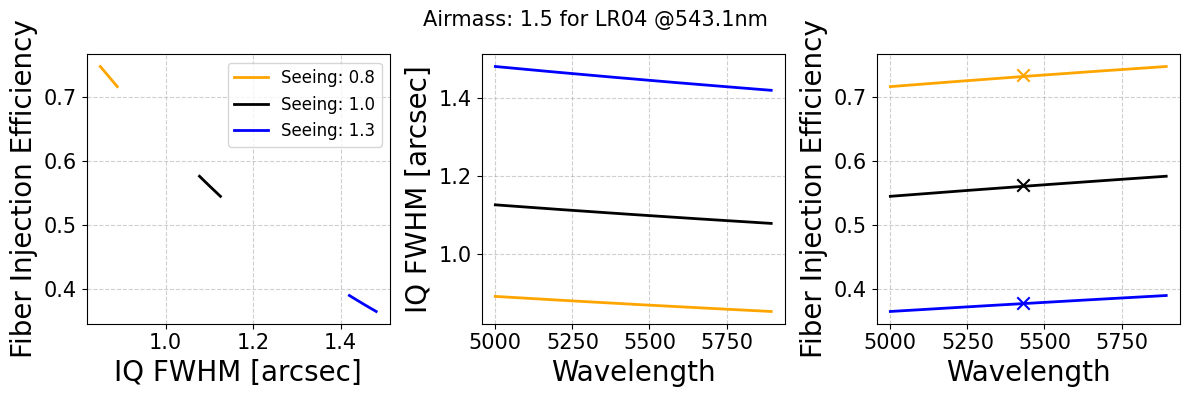

In [22]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.5 for LR04 @543.1nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1.5_LR04.pdf')
plt.show()


In [23]:
seeing  = [0.8, 1.0, 1.3]
airmass = 2.0
wave    = np.arange(5000,5900, 5)
diam    = 8.2
iq_ins  = 0.014 #0.014 for only the telescope for LR04

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [24]:
#ESO ETC
wv_refe  = 5431
eff_loss = [0.396,0.563,0.719]
fib_effi = [1-x for x in eff_loss]

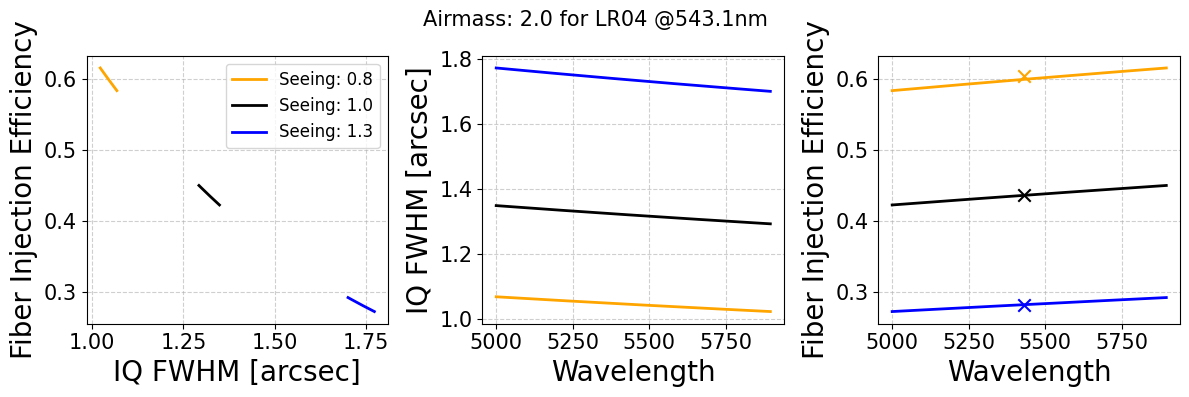

In [25]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 2.0 for LR04 @543.1nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass2.0_LR04.pdf')
plt.show()


## Let's try the same for another GIRAFFE mode (LR06@682.2)

In [26]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.0
wave    = np.arange(6440,7200, 5)
diam    = 8.2
iq_ins  = 0.018 #0.018 for only the telescope for LR06

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [27]:
#ESO ETC
wv_refe  = 6822
eff_loss = [0.078,0.208,0.410]
fib_effi = [1-x for x in eff_loss]

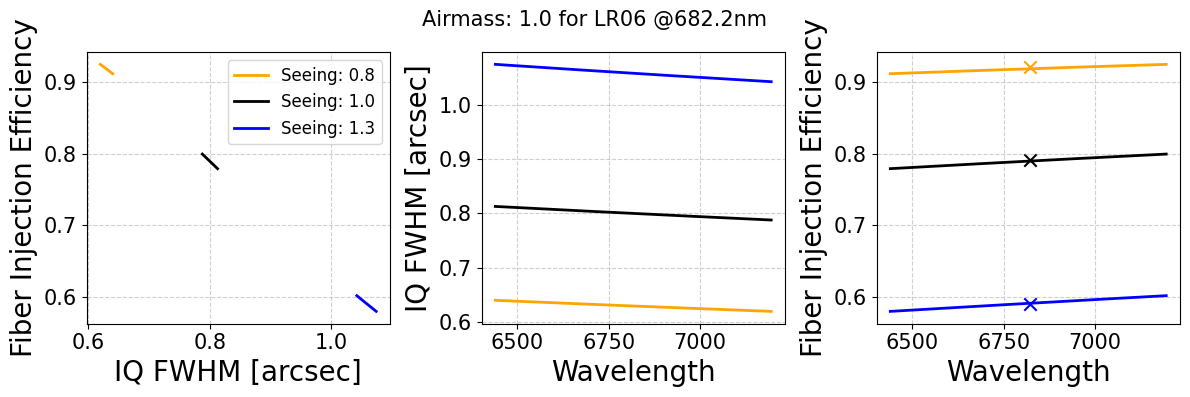

In [28]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.0 for LR06 @682.2nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1.0_LR06.pdf')
plt.show()


In [29]:
seeing  = [0.8, 1.0, 1.3]
airmass = 1.5 
wave    = np.arange(6440,7200, 5)
diam    = 8.2
iq_ins  = 0.018 #0.018 for only the telescope for LR06

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [30]:
#ESO ETC
wv_refe  = 6822
eff_loss = [0.225,0.396,0.587]
fib_effi = [1-x for x in eff_loss]

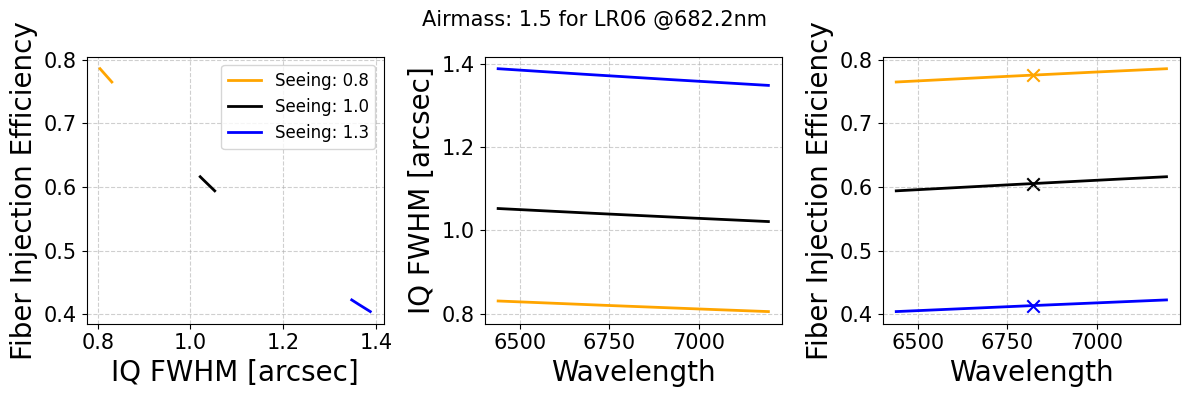

In [31]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 1.5 for LR06 @682.2nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass1.5_LR06.pdf')
plt.show()


In [32]:
seeing  = [0.8, 1.0, 1.3]
airmass = 2.0
wave    = np.arange(6440,7200, 5)
diam    = 8.2
iq_ins  = 0.018 #0.018 for only the telescope for LR06

iqs_gir = []

for i in range(0,len(seeing)):
    iqs = get_seeing_fwhm(seeing[i], airmass, wave, diam, iq_ins)
    iqs_gir = np.append(iqs_gir,iqs)

iqs_gir = iqs_gir.reshape(len(seeing), len(wave))


In [33]:
#ESO ETC
wv_refe  = 6822
eff_loss = [0.352,0.522,0.690]
fib_effi = [1-x for x in eff_loss]

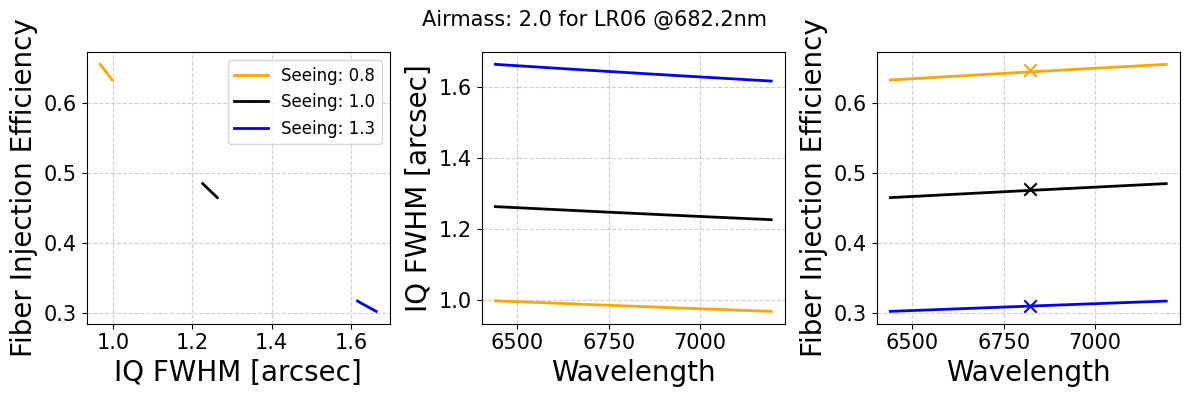

In [34]:
Df = 1.2 #Fiber Diameter

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(iqs_gir[0], T_gaussian(iqs_gir[0], Df),color='orange', label='Seeing: 0.8', linewidth=2)
ax[0].plot(iqs_gir[1], T_gaussian(iqs_gir[1], Df),color='black', label='Seeing: 1.0', linewidth=2)
ax[0].plot(iqs_gir[2], T_gaussian(iqs_gir[2], Df),color='blue', label='Seeing: 1.3', linewidth=2)

ax[0].set_xlabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[0].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[0].tick_params(axis='both', labelsize=15)
ax[0].grid(True, linestyle='--', alpha=0.6)


ax[1].plot(wave, iqs_gir[0], '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[1].plot(wave, iqs_gir[1], '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[1].plot(wave, iqs_gir[2], '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[1].set_xlabel(r'Wavelength', fontsize=20)
ax[1].set_ylabel(r'IQ FWHM [arcsec]', fontsize=20)
ax[1].tick_params(axis='both', labelsize=15)
ax[1].grid(True, linestyle='--', alpha=0.6)


ax[2].plot(wave, T_gaussian(iqs_gir[0], Df), '-', color='orange', label='Seeing: 0.8', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[1], Df), '-', color='black', label='Seeing: 1.0', linewidth=2)
ax[2].plot(wave, T_gaussian(iqs_gir[2], Df), '-', color='blue', label='Seeing: 1.3', linewidth=2)

ax[2].scatter(wv_refe,fib_effi[0],marker='x',color='orange',s=80)
ax[2].scatter(wv_refe,fib_effi[1],marker='x',color='black',s=80)
ax[2].scatter(wv_refe,fib_effi[2],marker='x',color='blue',s=80)

ax[2].set_xlabel(r'Wavelength', fontsize=20)
ax[2].set_ylabel(r'Fiber Injection Efficiency', fontsize=20)
ax[2].tick_params(axis='both', labelsize=15)
ax[2].grid(True, linestyle='--', alpha=0.6)

ax[0].legend(fontsize='large')
plt.suptitle(r'Airmass: 2.0 for LR06 @682.2nm', fontsize=15)
plt.tight_layout()

#plt.savefig('Fiber_Injection_Efficiency_Airmass2.0_LR06.pdf')
plt.show()
